In [2]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, auc, roc_curve, precision_recall_curve, average_precision_score
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2, ResNet50, InceptionV3
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model  # if using Keras
import matplotlib.image as img
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers

from PIL import Image
from imblearn.over_sampling import SMOTE

# **REMEMBER TO COPY PASTE NEW FOLDER**

### **Defining Paths for Training and Test Image Datasets**

In [131]:
train_benign_path = './melanoma_cancer_dataset/train/benign'
train_malignant_path = './melanoma_cancer_dataset/train/malignant'

test_path_benign = './melanoma_cancer_dataset/test/benign'
test_path_malignant = './melanoma_cancer_dataset/test/malignant'

### **Checking if any corrupted images exist**

In [133]:
def corrupted_img_check(directory):
    corrupted_images = []
    
    for file_name in os.listdir(directory):
        if file_name.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            file_path = os.path.join(directory, file_name)
            try:
                img = Image.open(file_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                corrupted_images.append(file_name)
    
    return corrupted_images

corrupted_benign = corrupted_img_check(train_benign_path)
corrupted_malignant = corrupted_img_check(train_malignant_path)

if corrupted_benign:
    print(f"Number of corrupted benign images: {corrupted_benign}")
else:
    print("No corrupted benign images found.")

if corrupted_malignant:
    print(f"Number of corrupted malignant images: {corrupted_malignant}")
else:
    print("No corrupted malignant images found.")


No corrupted benign images found.
No corrupted malignant images found.


##### Therefore, we do not have any corrupted images in the dataset.

### **Function to find and remove duplicate images**

In [ ]:
import imagehash
import os
from PIL import Image

def find_duplicates(image_dir):
    """Finds and prints duplicate images within a directory."""

    image_hashes = {}  # Store image hashes
    duplicates = []     # Store duplicate image paths

    for filename in os.listdir(image_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(image_dir, filename)
            try:
                with Image.open(img_path) as img:
                    hash = imagehash.phash(img)  # Calculate perceptual hash
                    if hash in image_hashes:
                        duplicates.append((image_hashes[hash], img_path))  # Store duplicate
                    else:
                        image_hashes[hash] = img_path  # Store unique hash
            except Exception as e:
                print(f"Error processing image: {img_path}, error: {e}")

    
    for _, duplicate_path in duplicates:
        os.remove(duplicate_path)
    
    if duplicates:
        print(f"Duplicate images removed.")
        
    return len(duplicates)

    # Print duplicates (original then duplicate below)
    '''if duplicates:
        print(f"Duplicates found in {image_dir}:")
        for original, duplicate in duplicates:
            print(f"Original: {original}")
            print(f"Duplicate: {duplicate}")
    else:
        print(f"No duplicates found in {image_dir}")'''

### **Checking if there exists any duplicated images and removing them.**

In [ ]:
print(f"Number of duplicate benign images(train): {find_duplicates(train_benign_path)}")
print(f"Number of duplicate malignant images(train): {find_duplicates(train_malignant_path)}")
print(f"Number of duplicate benign images(test): {find_duplicates(test_path_benign)}")
print(f"Number of duplicate malignant images(test): {find_duplicates(test_path_malignant)}")

Duplicate images removed.
Number of duplicate benign images(train): 8
Duplicate images removed.
Number of duplicate malignant images(train): 18
Duplicate images removed.
Number of duplicate benign images(test): 1
Number of duplicate malignant images(test): 0


##### Therefore, we have removed 26 duplicate images in training dataset and 1 duplicate image in test dataset.

### **Loading Image Data and Analyzing Class Distribution**

In [ ]:
train_benign_images = os.listdir(train_benign_path)   # list of names all images in the given path
train_malignant_images = os.listdir(train_malignant_path)  # list of names all images in the given path
test_benign_images = os.listdir(test_path_benign)
test_malignant_images = os.listdir(test_path_malignant)

benign_labels = np.zeros(len(train_benign_images))
malignant_labels = np.ones(len(train_malignant_images))

data = {
    "Category": ["Benign", "Malignant", "Benign", "Malignant"],
    "Type": ["Training", "Training", "Test", "Test"],
    "Count": [len(train_benign_images), len(train_malignant_images), len(test_benign_images), len(test_malignant_images)]
}

# Create DataFrame
df = pd.DataFrame(data)

# Style the table
styled_df = df.style.set_properties(**{
    'background-color': 'yellow',
    'color': 'black',
    'border-color': 'blue',
    'border-style': 'solid',
    'border-width': '1px',
    'font-weight': 'normal'
})

# Display the styled table
styled_df

,Category,Type,Count
0,Benign,Training,4992
1,Malignant,Training,4587
2,Benign,Test,499
3,Malignant,Test,500


### **Visualizing dataset class distribution with pie chart**

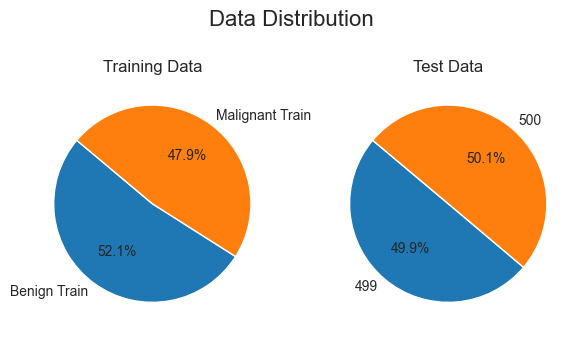

In [ ]:
counts_for_train_data = [len(train_benign_images), len(train_malignant_images)]
labels_of_train_data = ['Benign Train', 'Malignant Train']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pie(counts_for_train_data, labels=labels_of_train_data, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Training Data')

counts_of_test_data = [len(test_benign_images), len(test_malignant_images)]
labels_of_test_data = ['Benign Test', 'Malignant Test']
axes[1].pie(counts_of_test_data, labels=counts_of_test_data, autopct='%1.1f%%', startangle=140)
axes[0].figure.set_size_inches(7, 4)
axes[1].set_title('Test Data')

fig.suptitle('Data Distribution', fontsize=16)
plt.show()

##### From the chart, we can see that the train dataset is nearly balanced and the test dataset is balanced

### **Function to Display Sample RGB Images from a Specified Folder**

In [ ]:
def display_sample_RGB_images(images_list, path_of_folder, title, num):
    plt.figure(figsize=(15, 15))
    for i in range(num):
        plt.subplot(1, num, i+1)    # num of rows and columns(1=num of rows, num=num of columns, i+1=position)
        img = Image.open(os.path.join(path_of_folder, images_list[i]))
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

### **Displaying Sample Images of Benign and Malignant Classes**

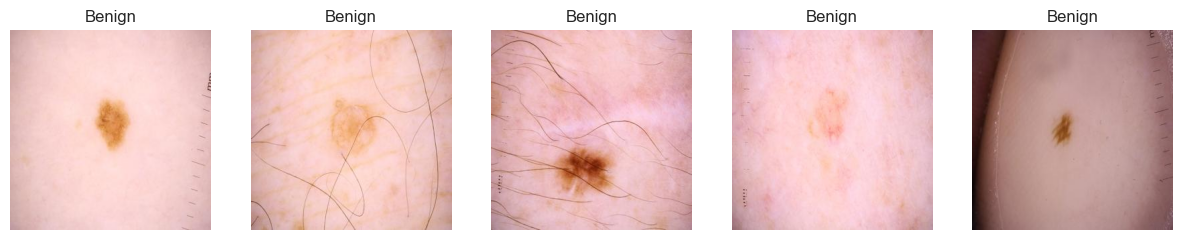

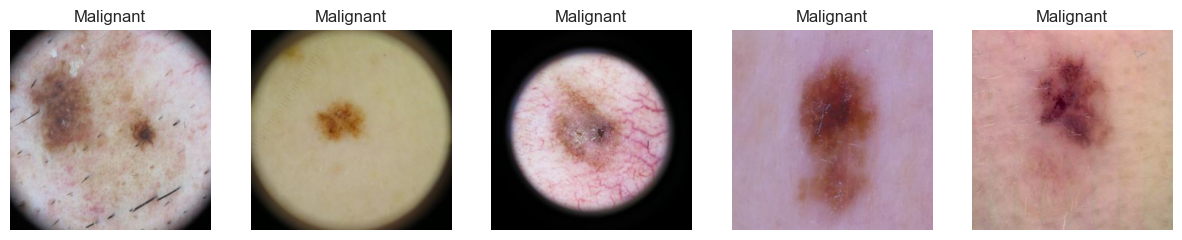

In [ ]:
display_sample_RGB_images(train_benign_images, train_benign_path, 'Benign', num=5)
display_sample_RGB_images(train_malignant_images, train_malignant_path, 'Malignant', num=5)

### **Function to get image sizes from different classes**

In [ ]:
def analyze_images(images_list, folder_path):
    sizes = []
    pixel_intensities = []
    red = []
    green = []
    blue = []
    for img in images_list:
        img = Image.open(os.path.join(folder_path, img))
        sizes.append(img.size)
        pixel_intensities.append(np.array(img).mean())
        red.append(np.array(img)[:, :, 0].mean())
        green.append(np.array(img)[:, :, 1].mean())
        blue.append(np.array(img)[:, :, 2].mean())
    return sizes, pixel_intensities, red, green, blue

### **Analyzing image sizes for benign and malignant classes**

In [ ]:
benign_images_sizes, benign_images_pixel_intensities, benign_images_red, benign_images_green, benign_images_blue = analyze_images(train_benign_images, train_benign_path)
malignant_images_sizes, malignant_images_pixel_intensities, malignant_images_red, malignant_images_green, malignant_images_blue = analyze_images(train_malignant_images, train_malignant_path)

sizes_data = {
    "Category": ["Benign", "Malignant"],
    "Sizes": [set(benign_images_sizes), set(malignant_images_sizes)]
}

pixel_intensities_data = {
    "Category": ["Benign", "Malignant"],
    "Pixel Intensity": [benign_images_pixel_intensities, malignant_images_pixel_intensities]
}

df_sizes = pd.DataFrame(sizes_data)
df_sizes["Sizes"] = df_sizes["Sizes"].astype(str).str.replace(r"[{}]", "", regex=True)

df_sizes = df_sizes.style.set_properties(**{
    'background-color': 'lightblue',
    'color': 'black',
    'border-color': 'black',
    'border-style': 'solid',
    'border-width': '1px',
    'font-weight': 'normal'
})

df_sizes

,Category,Sizes
0,Benign,"(300, 300)"
1,Malignant,"(300, 300)"


##### **All images have consistent shape of 300x300**

### **Plotting pixel intensities using KDE(Kernel Density Estimate) plot**

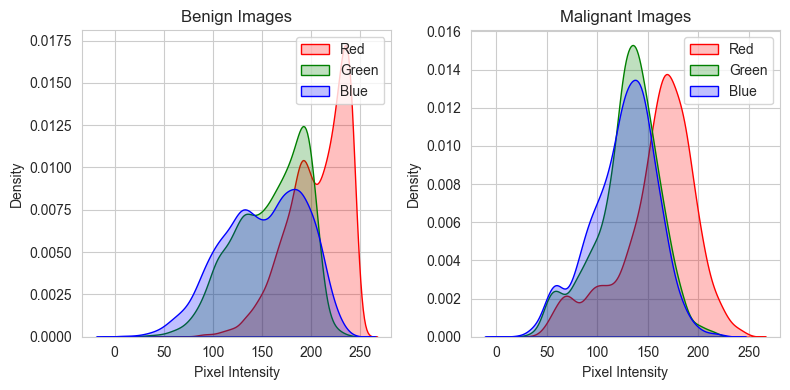

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.kdeplot(benign_images_red, color='red', label='Red', fill=True, ax=axes[0])
sns.kdeplot(benign_images_green, color='green', label='Green', fill=True, ax=axes[0])
sns.kdeplot(benign_images_blue, color='blue', label='Blue', fill=True, ax=axes[0])
axes[0].set_title('Benign Images')
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.kdeplot(malignant_images_red, color='red', label='Red', fill=True, ax=axes[1])
sns.kdeplot(malignant_images_green, color='green', label='Green', fill=True, ax=axes[1])
sns.kdeplot(malignant_images_blue, color='blue', label='Blue', fill=True, ax=axes[1])
axes[1].set_title('Malignant Images')
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()

### **Function to get grayscale intensities**

In [ ]:
def convert_to_grayscale(images_list, folder_path):
    grayScale_intensities = []
    grayScale_images = []
    for image in images_list:
        img_path = os.path.join(folder_path, image)   # path of each image
        img = Image.open(img_path).convert('L')     # convert image to grayscale
        grayScale_intensities.append(np.array(img).mean())
        grayScale_images.append(img)
    return grayScale_intensities, grayScale_images

### **Converting RGB images to Grayscale and checking pixel intensity through KDE plot**

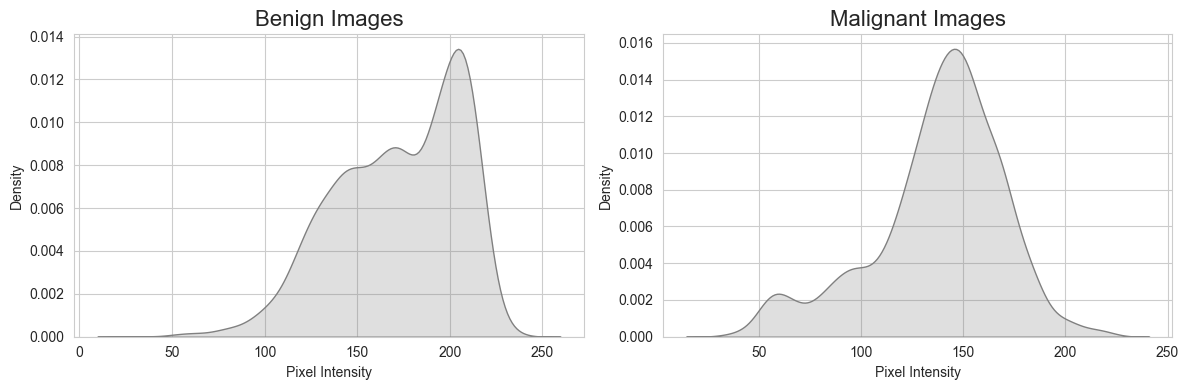

In [ ]:
benign_grayScale_intensities, benign_grayScale_images = convert_to_grayscale(train_benign_images, train_benign_path)
malignant_grayScale_intensities, malignant_grayScale_images = convert_to_grayscale(train_malignant_images, train_malignant_path)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.kdeplot(benign_grayScale_intensities, color='grey', label='Benign', fill=True, ax=axes[0])
axes[0].set_title('Benign Images', fontsize=16)
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Density')

sns.kdeplot(malignant_grayScale_intensities, color='grey', label='Malignant', fill=True, ax=axes[1])
axes[1].set_title('Malignant Images', fontsize=16)
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

##### Here, from the above plots, we can see that the pixel intensity of malignant images is higher than benign images.

### **Function to display images.**

In [ ]:
def display_images(images_list, title, num):
    plt.figure(figsize=(15, 15))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(images_list[i], cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

### **Calculating average pixel intensity for benign and malignant images**

In [ ]:
average_pixel_intensity = {
    "Category": ["Benign", "Malignant"],
    "Average Pixel Intensity": [
        np.mean(benign_grayScale_intensities),
        np.mean(malignant_grayScale_intensities)
        ]
}

df_average_pixel_intensity = pd.DataFrame(average_pixel_intensity)

df_average_pixel_intensity["Average Pixel Intensity"] = df_average_pixel_intensity["Average Pixel Intensity"].map("{:.2f}".format)


df_average_pixel_intensity = df_average_pixel_intensity.style.set_properties(**{
    'background-color': 'lightblue',
    'color': 'black',
    'border-color': 'black',
    'border-style': 'solid',
    'border-width': '1px',
    'font-weight': 'normal'
})

df_average_pixel_intensity

,Category,Average Pixel Intensity
0,Benign,172.21
1,Malignant,137.52


##### Therefore, Benign images have a greater average pixel intensity as compared to Malignant images.

### **Function to normalize images**

In [ ]:
def normalize_images(images_list, target_size=(128, 128)):
    normalized_images = []
    for img in images_list:
        img_resized = img.resize(target_size)
        normalized_img = np.array(img_resized)/255.0
        normalized_images.append(normalized_img)
    return normalized_images

### **Applying the above 'normalize_images' function to normalize GrayScale benign and malignant images**

In [ ]:
benign_normalized_images = normalize_images(benign_grayScale_images)

In [ ]:
malignant_normalized_images = normalize_images(malignant_grayScale_images)

##### **Compairing RGB, GrayScale and Normalized images by displaying**

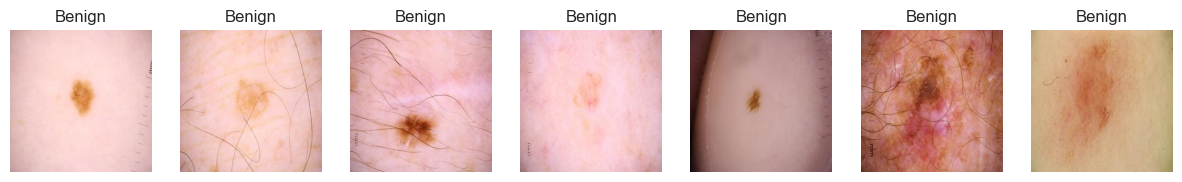

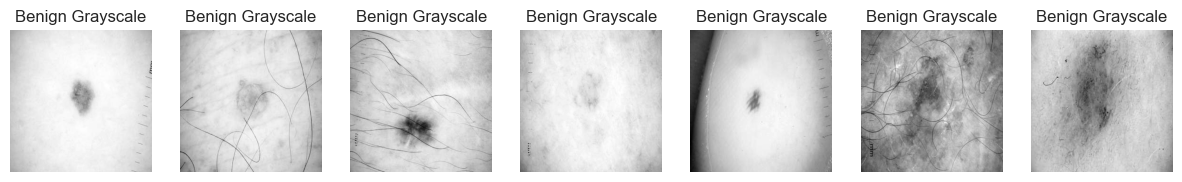

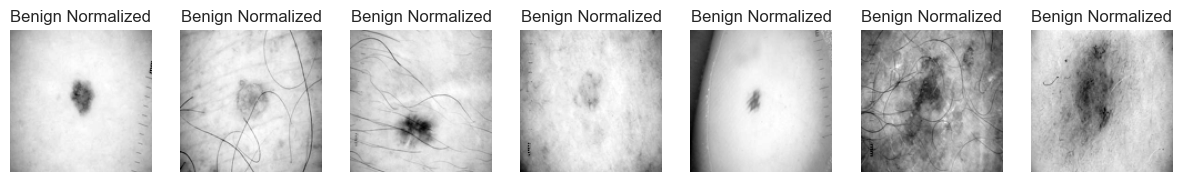

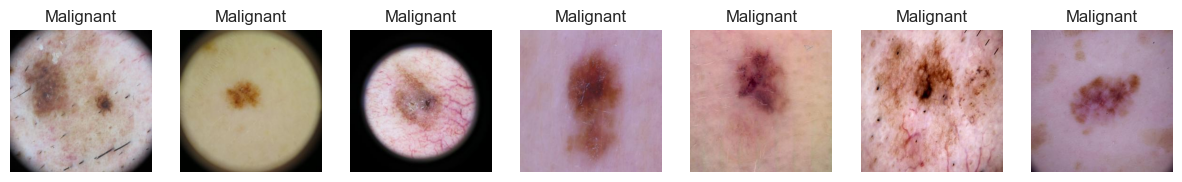

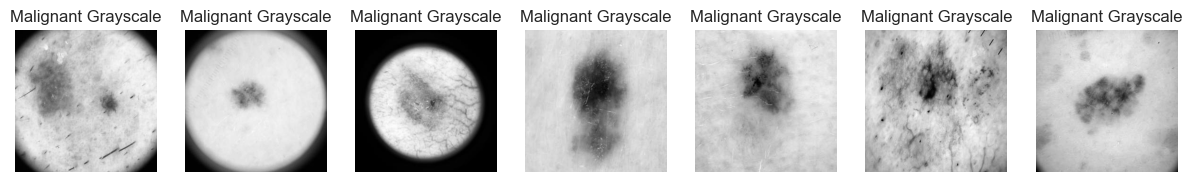

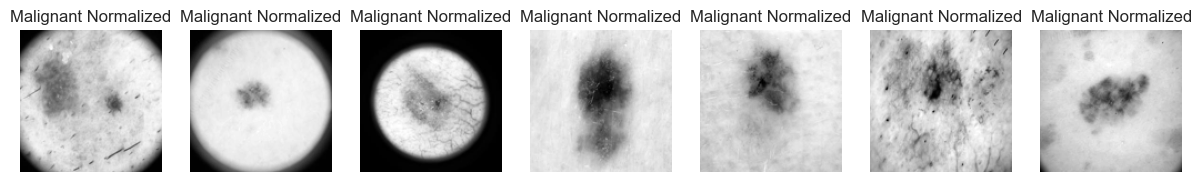

In [ ]:
display_sample_RGB_images(train_benign_images, train_benign_path, 'Benign', num=7)
display_images(benign_grayScale_images, 'Benign Grayscale', num=7)
display_images(benign_normalized_images, 'Benign Normalized', num=7)
display_sample_RGB_images(train_malignant_images, train_malignant_path, 'Malignant', num=7)
display_images(malignant_grayScale_images, 'Malignant Grayscale', num=7)
display_images(malignant_normalized_images, 'Malignant Normalized', num=7)

### **Data augmentation**

In [ ]:
augmented_dir = "./melanoma_cancer_dataset/augmented"

# Create augmented directory if it doesn't exist
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)

path_benign_augmented_dir = os.path.join(augmented_dir, 'benign')
if not os.path.exists(path_benign_augmented_dir):
    os.makedirs(path_benign_augmented_dir)


path_malignant_augmented_dir = os.path.join(augmented_dir, 'malignant')
if not os.path.exists(path_malignant_augmented_dir):
    os.makedirs(path_malignant_augmented_dir)

# Define the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

benign_generator = train_datagen.flow_from_directory(
    directory='./melanoma_cancer_dataset/train',
    classes=['benign'],
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    save_to_dir=path_benign_augmented_dir,
    save_prefix='benign',
    save_format='jpg'
)

malignant_generator = train_datagen.flow_from_directory(
    directory='./melanoma_cancer_dataset/train',
    classes=['malignant'],
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    save_to_dir=path_malignant_augmented_dir,
    save_prefix='malignant',
    save_format='jpg'
)

test_generator = test_datagen.flow_from_directory(
    directory='./melanoma_cancer_dataset/test',
    target_size=(224, 224),
    batch_size=1, 
    class_mode='binary'
)

num_augmented_images_per_original_image = 5

total_benign_images = len(benign_generator.filenames)
total_malignant_images = len(malignant_generator.filenames)

for i in range(total_benign_images * num_augmented_images_per_original_image):
    next(benign_generator)

for i in range(total_malignant_images * num_augmented_images_per_original_image):
    next(malignant_generator)

Found 4992 images belonging to 1 classes.
Found 4587 images belonging to 1 classes.
Found 999 images belonging to 2 classes.


### **Compare RGB, grayscale and its 5 augmented images by displaying them**

In [ ]:
augmented_benign_images = os.listdir(path_benign_augmented_dir)
augmented_malignant_images = os.listdir(path_malignant_augmented_dir)

benign_augmented_images_full_path = []

for img in augmented_benign_images:
    img_path = os.path.join(path_benign_augmented_dir, img)
    with Image.open(img_path) as img_obj:
        benign_augmented_images_full_path.append(img_obj.copy())

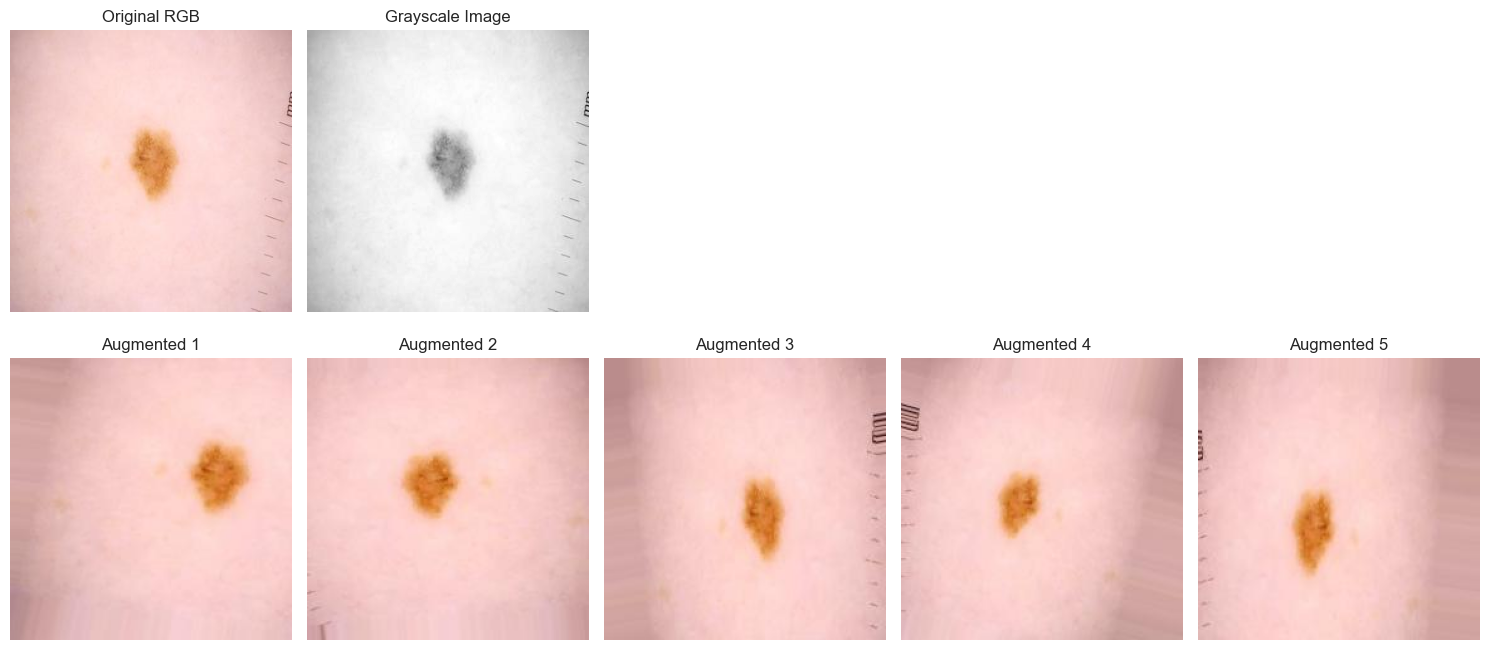

In [ ]:

plt.figure(figsize=(15, 10))

# Display Original RGB Image
plt.subplot(3, 5, 1)
plt.imshow(Image.open(os.path.join(train_benign_path, train_benign_images[0])))
plt.title('Original RGB')
plt.axis('off')

# Display Grayscale Image
plt.subplot(3, 5, 2)
plt.imshow(benign_grayScale_images[0], cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

# Display 5 Augmented Images
for i in range(5):
    plt.subplot(3, 5, i + 6)
    plt.imshow(benign_augmented_images_full_path[i])
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Building the CNN Model for _Original RGB Images(No Duplicates)_**

#### **Defining Paths and Data Generators**

In [ ]:
train_datagen_original = ImageDataGenerator(rescale=1./255)

train_generator_original = train_datagen_original.flow_from_directory(
    directory='./melanoma_cancer_dataset/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

train_datagen_augmented = ImageDataGenerator(rescale=1./255)

train_datagen_augmented = train_datagen_augmented.flow_from_directory(
    directory='./melanoma_cancer_dataset/augmented',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory='./melanoma_cancer_dataset/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 9579 images belonging to 2 classes.
Found 47895 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


#### **Define RGB CNN Model**

In [ ]:
model11 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    # layers.Conv2D(128, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D(2, 2),
    # layers.Dropout(0.4),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

#### **Compile the Model**

In [ ]:
model11.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### **Defining Early Stopping**

In [ ]:
early_stopping = EarlyStopping(
    monitor='loss',
    patience=8,
    mode='min',
    restore_best_weights=True
)

#### **Train the Model**

In [ ]:
history11 = model11.fit(
    train_generator_original,
    epochs=5,
    callbacks=[early_stopping]
)


c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 232s 764ms/step - accuracy: 0.8248 - loss: 0.4921
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 228s 760ms/step - accuracy: 0.8614 - loss: 0.3239
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 189s 630ms/step - accuracy: 0.8855 - loss: 0.2751
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 222s 738ms/step - accuracy: 0.8898 - loss: 0.2597
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 223s 744ms/step - accuracy: 0.9039 - loss: 0.2401


#### **Plotting the Training and Validation Accuracy and ROC Curve**

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step


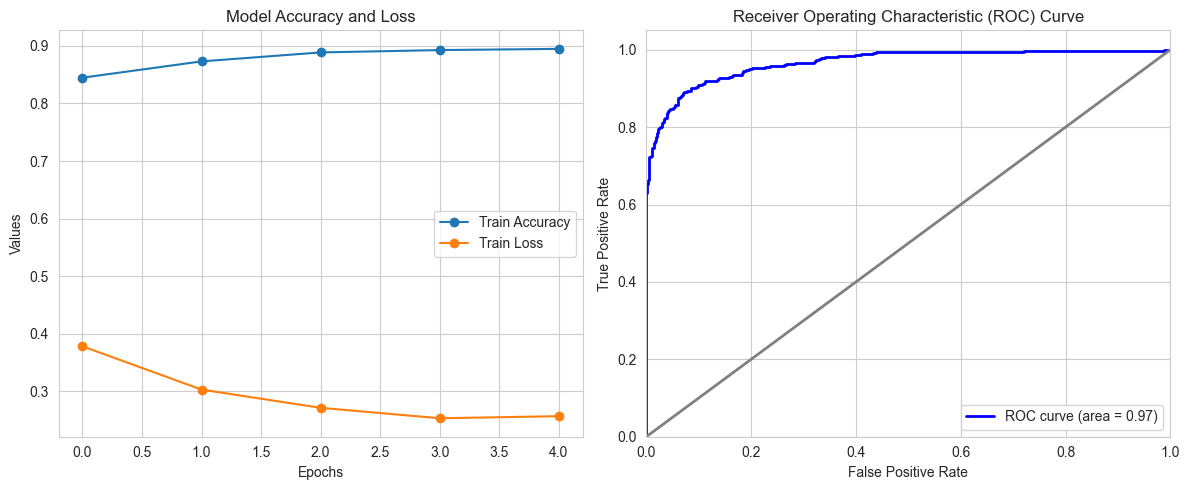

In [ ]:
history_dict = history11.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label="Train Accuracy", marker='o')
plt.plot(history_dict['loss'], label="Train Loss", marker='o')
plt.title('Model Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()

y_true = test_generator.classes
y_pred_prob = model11.predict(test_generator)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### **Evaluate Model Performance on Test Data**

In [ ]:
rgb_loss11, rgb_accuracy11 = model11.evaluate(test_generator)

c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.9265 - loss: 0.1880


#### **Display Test Accuracy and Loss**

In [ ]:
print(f"Test Accuracy: {rgb_accuracy11 * 100:.2f}%")
print(f"Test Loss: {rgb_loss11:.4f}")

Test Accuracy: 89.39%
Test Loss: 0.2470


#### **Generate Predictions on Test Data**

In [ ]:
predictions_rgb_original11 = model11.predict(test_generator)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step


#### **Convert Predicted Probabilities to Binary Classes**

In [ ]:
predictions_rgb_original11 = np.where(predictions_rgb_original11 > 0.5, 1, 0)

#### **Compute Confusion Matrix for Model Predictions**

In [ ]:
rgb_confusion_matrix11 = confusion_matrix(test_generator.classes, model11.predict(test_generator).round())

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step 


#### **Plot Confusion Matrix**

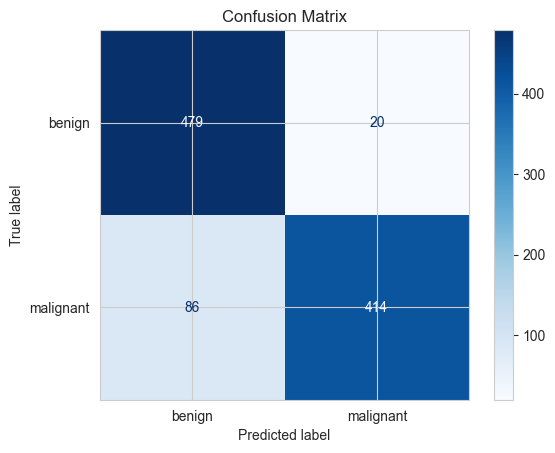

<Figure size 10000x5000 with 0 Axes>

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=rgb_confusion_matrix11, display_labels=test_generator.class_indices)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.figure(figsize=(100, 50))
plt.show()

#### **Display Classification Report**

In [ ]:
print(classification_report(test_generator.classes, model11.predict(test_generator).round(), target_names=['Benign', 'Malignant']))

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step 
              precision    recall  f1-score   support

      Benign       0.85      0.96      0.90       499
   Malignant       0.95      0.83      0.89       500

    accuracy                           0.89       999
   macro avg       0.90      0.89      0.89       999
weighted avg       0.90      0.89      0.89       999



## **Building the CNN Model for _Grayscale Normalized Images_**

#### **Prepare Grayscale Image Data Generators for Training and Testing**

In [ ]:
train_datagen_normalized = ImageDataGenerator(rescale=1./255)

train_generator_normalized = train_datagen_normalized.flow_from_directory(
    directory='./melanoma_cancer_dataset/train',
    target_size=(64, 64),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=True
)

test_generator_normalized = test_datagen.flow_from_directory(
    './melanoma_cancer_dataset/test',
    target_size=(64, 64),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 9579 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


#### **Define Grayscale Normalized CNN Model**

In [ ]:

gray_normalized_model8 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),

    # layers.Conv2D(256, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D(2, 2),
    # layers.Dropout(0.4),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Compile Grayscale Normalized CNN Model**

In [ ]:
gray_normalized_model8.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

#### **Train Grayscale Normalized CNN Model**

In [ ]:
history_gray_normalized08 = gray_normalized_model8.fit(train_generator_normalized, epochs=5, callbacks=[early_stopping])

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.7106 - loss: 0.5743
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.8145 - loss: 0.3761
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.8323 - loss: 0.3465
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - accuracy: 0.8463 - loss: 0.3357
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.8529 - loss: 0.3325


#### **Evaluate Grayscale Normalized CNN Model on Test Data**

In [ ]:
loss_normalized_gray8, accuracy_normalized_gray8 = gray_normalized_model8.evaluate(test_generator_normalized)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8781 - loss: 0.4334


#### **Display Test Accuracy and Loss for Grayscale Normalized Model**

In [ ]:
print(f"Test Accuracy: {accuracy_normalized_gray8}")
print(f"Test Loss: {loss_normalized_gray8}")

Test Accuracy: 0.8638638854026794
Test Loss: 0.42027220129966736


#### **Display Training Loss and Accuracy Curve and ROC Curve**

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step


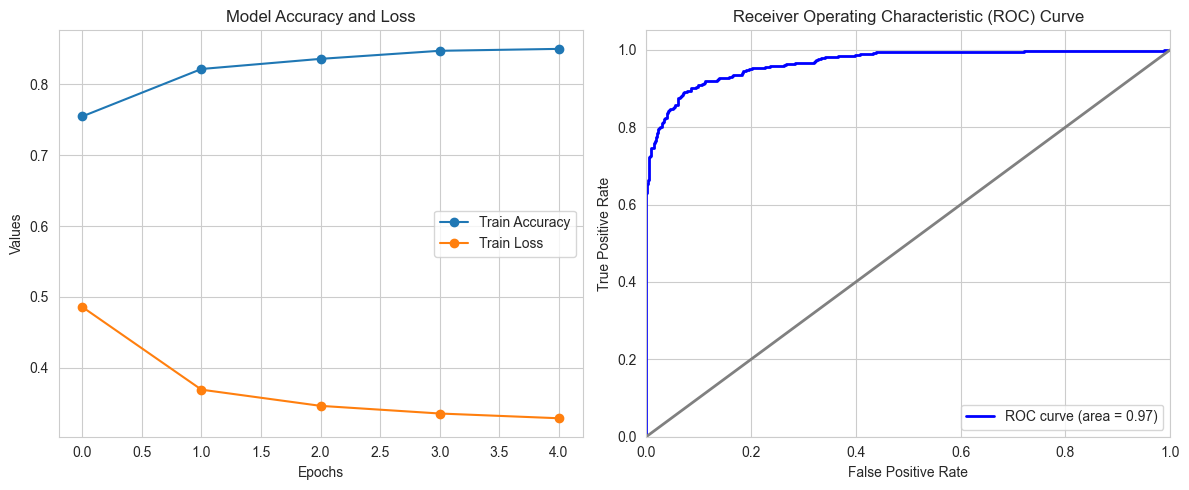

In [ ]:
gray_normalized_history_dict = history_gray_normalized08.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(gray_normalized_history_dict['accuracy'], label="Train Accuracy", marker='o')
plt.plot(gray_normalized_history_dict['loss'], label="Train Loss", marker='o')
plt.title('Model Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()

y_true = test_generator_normalized.classes
y_pred_prob = model11.predict(test_generator)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

#### **Generate Predictions and Compute Confusion Matrix for Grayscale Normalized Model**

In [ ]:
predictions_original8 = gray_normalized_model8.predict(test_generator_normalized)

predictions_original8 = np.where(predictions_original8 > 0.5, 1, 0)

confusion_mtx8 = confusion_matrix(test_generator_normalized.classes, predictions_original8.round())

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


#### **Plot Confusion Matrix for Grayscale Normalized Model**

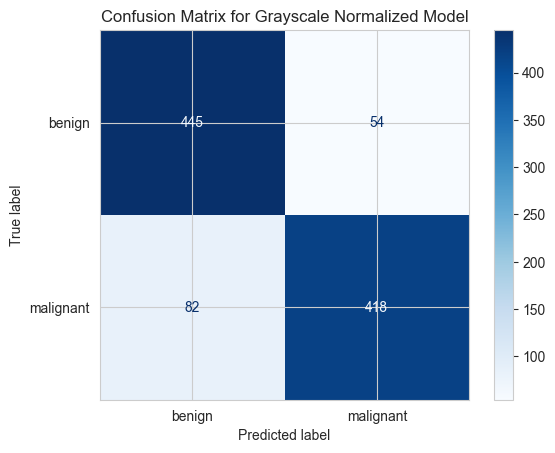

<Figure size 10000x5000 with 0 Axes>

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx8, display_labels=test_generator.class_indices)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Grayscale Normalized Model')
plt.figure(figsize=(100, 50))
plt.show()



#### **Display Classification Report for Grayscale Normalized Model**

In [ ]:
print(classification_report(test_generator_normalized.classes, predictions_original8, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.84      0.89      0.87       499
   Malignant       0.89      0.84      0.86       500

    accuracy                           0.86       999
   macro avg       0.86      0.86      0.86       999
weighted avg       0.87      0.86      0.86       999



## **Building the CNN Model for _Augmenetd Grayscale Normalized Images_**

#### **Prepare Augmented Grayscale Image Data Generators for Training and Testing**

In [3]:
aug_datagen = ImageDataGenerator(rescale=1./255)

train_augmented_generator = aug_datagen.flow_from_directory(
    directory='./melanoma_cancer_dataset/augmented',
    target_size=(64, 64),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=True
)

test_augmented_generator = aug_datagen.flow_from_directory(
    directory='./melanoma_cancer_dataset/test',
    target_size=(64, 64),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False
)

Found 47895 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


#### **Define Augmented Grayscale Normalized CNN Model**

In [4]:
aug_model17 = keras.Sequential([

    Input(shape=(64, 64, 1)),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),

    layers.Dense(32, activation='relu'),

    layers.Dense(1, activation='sigmoid')
])

#### **Compile the Augmented Grayscale Normalized CNN Model**

In [5]:
aug_model17.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### **Train the Augmented Grayscale Normalized CNN Model**

In [7]:
aug_history17 = aug_model17.fit(train_augmented_generator, epochs=5)

c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 115s 76ms/step - accuracy: 0.7675 - loss: 0.4637
Epoch 2/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 167s 111ms/step - accuracy: 0.8580 - loss: 0.3287
Epoch 3/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 128s 85ms/step - accuracy: 0.8751 - loss: 0.3014
Epoch 4/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 112s 75ms/step - accuracy: 0.8842 - loss: 0.2789
Epoch 5/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 129s 86ms/step - accuracy: 0.8897 - loss: 0.2716


#### **Evaluate Augmented Grayscale Normalized CNN Model on Test Data**

In [8]:
aug_loss17, aug_accuracy17 = aug_model17.evaluate(test_augmented_generator)

c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9247 - loss: 0.2065


#### **Display Test Accuracy and Loss for Augmented Grayscale Normalized Model**

In [9]:
print(f"Test Accuracy: {aug_accuracy17}")
print(f"Test Loss: {aug_loss17}")

Test Accuracy: 0.8558558821678162
Test Loss: 0.3148570656776428


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


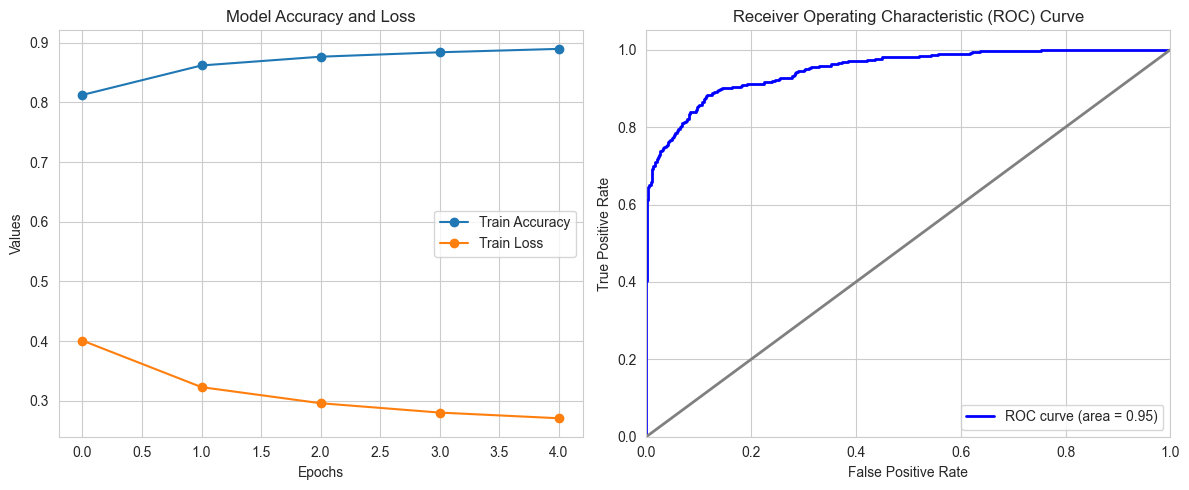

In [10]:
gray_normalized_aug_history_dict = aug_history17.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(gray_normalized_aug_history_dict['accuracy'], label="Train Accuracy", marker='o')
plt.plot(gray_normalized_aug_history_dict['loss'], label="Train Loss", marker='o')
plt.title('Model Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()

y_true = test_augmented_generator.classes
y_pred_prob = aug_model17.predict(test_augmented_generator)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

#### **Make Predictions on Test Data**

In [11]:
aug_predictions17 = aug_model17.predict(test_augmented_generator)

aug_predictions17 = np.where(aug_predictions17 > 0.5, 1, 0)

aug_confusion_matrix17 = confusion_matrix(test_augmented_generator.classes, aug_predictions17.round())

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


#### **Plot Confusion Matrix for Augmented Grayscale Normalized Model**

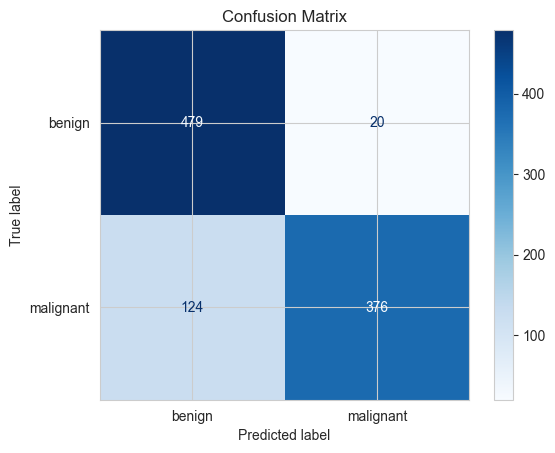

<Figure size 10000x5000 with 0 Axes>

In [12]:
aug_disp = ConfusionMatrixDisplay(confusion_matrix=aug_confusion_matrix17, display_labels=test_augmented_generator.class_indices)
aug_disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.figure(figsize=(100, 50))
plt.show()

#### **Print Classification Report for CNN Model for Augmented Grayscale Normalized Images**

In [13]:
print(classification_report(test_augmented_generator.classes, aug_predictions17, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.79      0.96      0.87       499
   Malignant       0.95      0.75      0.84       500

    accuracy                           0.86       999
   macro avg       0.87      0.86      0.85       999
weighted avg       0.87      0.86      0.85       999



## **Building the CNN Model for _Augmented RGB Images_**

#### **Prepare Augmented RGB Image Data Generators for Training and Testing**

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

RGB_train_generator = train_datagen.flow_from_directory(
    directory='./melanoma_cancer_dataset/augmented',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

RGB_test_generator = test_datagen.flow_from_directory(
    directory='./melanoma_cancer_dataset/test',
    target_size=(64, 64),
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False
)

Found 47895 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


#### **Define Augmented RGB CNN Model**

In [ ]:
rgb_augmented_model10 = keras.Sequential([

    Input(shape=(64, 64, 3)),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),

    layers.Dense(32, activation='relu'),

    layers.Dense(1, activation='sigmoid')
])

#### **Compile the Augmented RGB CNN Model**

In [ ]:
rgb_augmented_model10.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### **Train the Augmented RGB CNN Model**

In [ ]:
rgb_aug_history10 = rgb_augmented_model10.fit(RGB_train_generator, epochs=5, callbacks=[early_stopping])

Epoch 1/5


c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1497/1497 ━━━━━━━━━━━━━━━━━━━━ 110s 72ms/step - accuracy: 0.8202 - loss: 0.3940
Epoch 2/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 88s 59ms/step - accuracy: 0.8864 - loss: 0.2793
Epoch 3/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 74s 50ms/step - accuracy: 0.8966 - loss: 0.2544
Epoch 4/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 86s 57ms/step - accuracy: 0.9009 - loss: 0.2413
Epoch 5/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 90s 60ms/step - accuracy: 0.9072 - loss: 0.2281


#### **Evaluate Augmented RGB CNN Model on Test Data**

In [ ]:
rgb_loss10, rgb_accuracy10 = rgb_augmented_model10.evaluate(RGB_test_generator)

c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8719 - loss: 0.3282


#### **Display Test Accuracy and Loss for Augmented RGB Model**

In [ ]:
print(f"Test Accuracy: {rgb_accuracy10}")
print(f"Test Loss: {rgb_loss10}")

Test Accuracy: 0.8918918967247009
Test Loss: 0.24406865239143372


### **Displaying Train Loss and Accuracy Curve, ROC Curve for Augmented RGB Model**

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


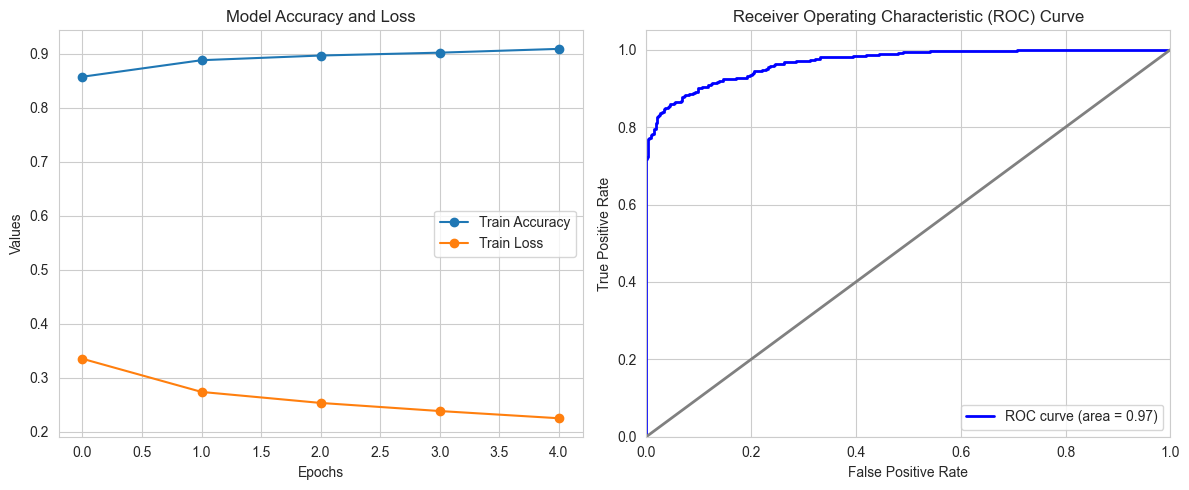

In [ ]:
rgb_aug_history_dict = rgb_aug_history10.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rgb_aug_history_dict['accuracy'], label="Train Accuracy", marker='o')
plt.plot(rgb_aug_history_dict['loss'], label="Train Loss", marker='o')
plt.title('Model Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()

y_true = RGB_test_generator.classes
y_pred_prob = rgb_augmented_model10.predict(RGB_test_generator)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

#### **Prediction Test Data**

In [ ]:
aug_rgb_predictions16 = rgb_augmented_model10.predict(RGB_test_generator)

aug_rgb_predictions16 = np.where(aug_rgb_predictions16 > 0.5, 1, 0)

aug_rgb_confusion_matrix16 = confusion_matrix(RGB_test_generator.classes, aug_rgb_predictions16.round())

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


#### **Plotting Confusion Matrix for Augmented RGB Model**

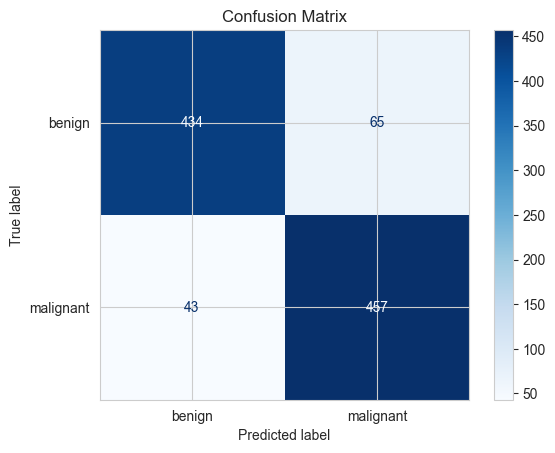

<Figure size 10000x5000 with 0 Axes>

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=aug_rgb_confusion_matrix16, display_labels=RGB_test_generator.class_indices)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.figure(figsize=(100, 50))
plt.show()

#### **Display Classification Report for Augmented RGB Model**

In [ ]:
print(classification_report(RGB_test_generator.classes, aug_rgb_predictions16, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.91      0.87      0.89       499
   Malignant       0.88      0.91      0.89       500

    accuracy                           0.89       999
   macro avg       0.89      0.89      0.89       999
weighted avg       0.89      0.89      0.89       999



### **VGG16**

#### **Base Model for VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model

base_model6 = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3), pooling='max')


#### **Adding Custom Layers to VGG16 Model**

In [ ]:
vgg16_model6 = keras.Sequential([
    base_model6,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

#### **Compile the VGG16 Model**

In [ ]:
vgg16_model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### **Train the VGG16 Model**

In [ ]:
history_vgg16_model6 = vgg16_model6.fit(RGB_train_generator, epochs=5)

Epoch 1/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 2254s 2s/step - accuracy: 0.7637 - loss: 0.6097
Epoch 2/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1696s 1s/step - accuracy: 0.7829 - loss: 0.4638
Epoch 3/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1816s 1s/step - accuracy: 0.8640 - loss: 0.3251
Epoch 4/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1820s 1s/step - accuracy: 0.8844 - loss: 0.2855
Epoch 5/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1814s 1s/step - accuracy: 0.8511 - loss: 0.3505


#### **Evaluate VGG16 Model on Test Data and Print Test Accuracy and Loss**

In [ ]:
loss_vgg16_model6, accuracy_vgg16_model6 = vgg16_model6.evaluate(RGB_test_generator)

print(f"Test Accuracy: {accuracy_vgg16_model6}")
print(f"Test Loss: {loss_vgg16_model6}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 334ms/step - accuracy: 0.8861 - loss: 0.2750
Test Accuracy: 0.8958958983421326
Test Loss: 0.24691882729530334


#### **Plot Training and Validation Accuracy and ROC Curve for VGG16 Model**

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step


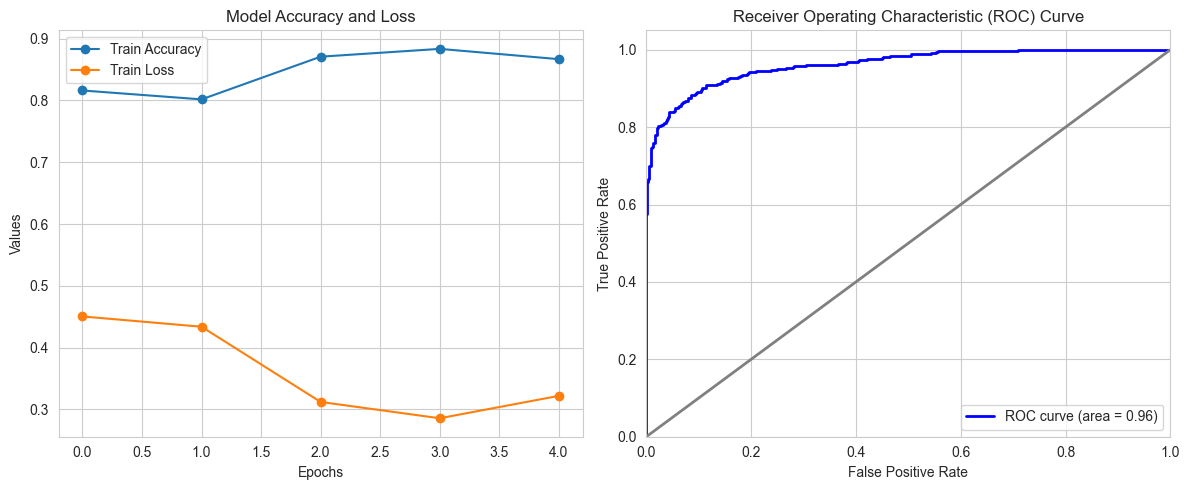

In [ ]:
vgg_history_dict = history_vgg16_model6.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history_dict['accuracy'], label="Train Accuracy", marker='o')
plt.plot(vgg_history_dict['loss'], label="Train Loss", marker='o')
plt.title('Model Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()

y_true = RGB_test_generator.classes
y_pred_prob = vgg16_model6.predict(RGB_test_generator)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

#### **Predict on Test Data**

In [ ]:
vgg_predictions = vgg16_model6.predict(RGB_test_generator)

vgg_predictions = np.where(vgg_predictions > 0.5, 1, 0)

vgg_confusion_matrix = confusion_matrix(RGB_test_generator.classes, vgg_predictions.round())

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 245ms/step


#### **Display Confusion Matrix**

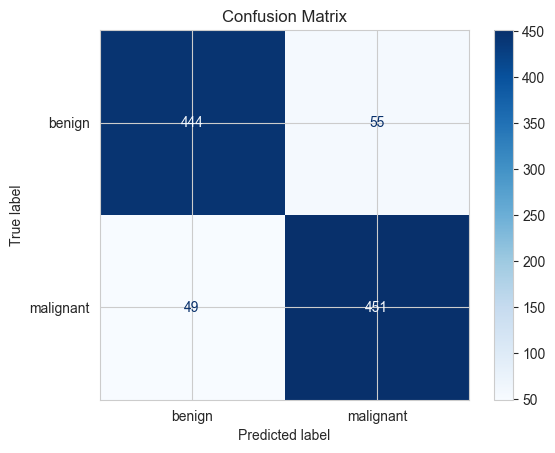

<Figure size 10000x5000 with 0 Axes>

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=vgg_confusion_matrix, display_labels=RGB_test_generator.class_indices)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.figure(figsize=(100, 50))
plt.show()

#### **Classification Report of VGG16 Model**

In [ ]:
print(classification_report(RGB_test_generator.classes, vgg_predictions, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.90      0.89      0.90       499
   Malignant       0.89      0.90      0.90       500

    accuracy                           0.90       999
   macro avg       0.90      0.90      0.90       999
weighted avg       0.90      0.90      0.90       999



#### **Saving the VGG16 Model**

In [138]:
# Save the vgg16 model
vgg16_model6.save('./vgg16_model6.h5')

### **VGG19**

#### **Base Model for VGG19**

In [ ]:
vgg19_base_model = VGG19(weights='imagenet', include_top=False, input_shape=(64, 64, 3), pooling='max')

#### **Adding Custom Layers to VGG19 Model**

In [ ]:
vgg19_model = keras.Sequential([
    vgg19_base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

#### **Compile the VGG19 Model**

In [ ]:
vgg19_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### **Train the VGG19 Model**

In [ ]:
vgg19_history01 = vgg19_model.fit(RGB_train_generator, epochs=5)

Epoch 1/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 2630s 2s/step - accuracy: 0.5053 - loss: 0.8052
Epoch 2/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 2616s 2s/step - accuracy: 0.5219 - loss: 0.6969
Epoch 3/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 3751s 3s/step - accuracy: 0.5179 - loss: 0.6926
Epoch 4/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 2328s 2s/step - accuracy: 0.5226 - loss: 0.6921
Epoch 5/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 2433s 2s/step - accuracy: 0.5239 - loss: 0.6920


#### **Evaluating VGG19 Model on Test Data**

In [ ]:
vgg19_loss01, vgg19_accuracy01 = vgg19_model.evaluate(RGB_test_generator)

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.8199 - loss: 0.6727


#### **Display Test Accuracy and Loss for VGG19 Model**

In [ ]:
print(f"Test Accuracy: {vgg19_accuracy01}")
print(f"Test Loss: {vgg19_loss01}")

Test Accuracy: 0.49949949979782104
Test Loss: 0.6937205195426941


#### **Plot Training and Validation Accuracy and ROC Curve for VGG19 Model**

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step


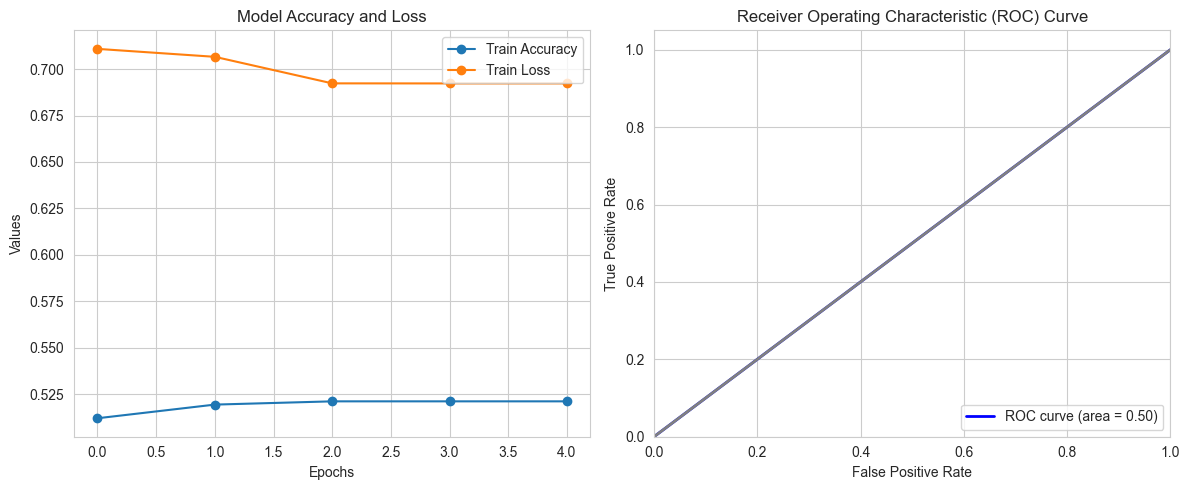

In [134]:
vgg19_history_dict = vgg19_history01.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg19_history_dict['accuracy'], label="Train Accuracy", marker='o')
plt.plot(vgg19_history_dict['loss'], label="Train Loss", marker='o')
plt.title('Model Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()

y_true = RGB_test_generator.classes
y_pred_prob = vgg19_model.predict(RGB_test_generator)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

#### **Generate Predictions on Test Data**

In [135]:
vgg19_predictions01 = vgg19_model.predict(RGB_test_generator)

vgg19_predictions01 = np.where(vgg19_predictions01 > 0.5, 1, 0)

vgg19_confusion_matrix01 = confusion_matrix(RGB_test_generator.classes, vgg19_predictions01.round())

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step


#### **Plot Confusion Matrix for VGG19 Model**

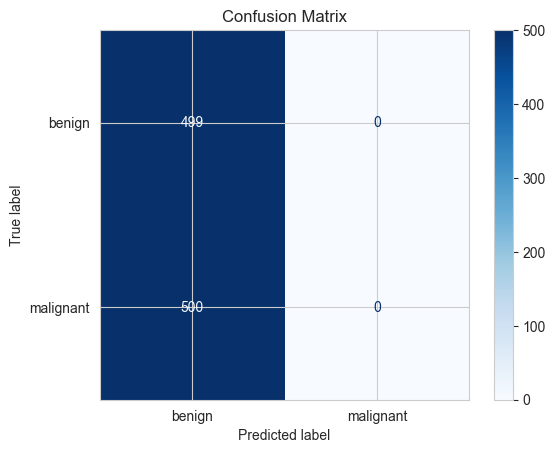

<Figure size 10000x5000 with 0 Axes>

In [136]:
disp = ConfusionMatrixDisplay(confusion_matrix=vgg19_confusion_matrix01, display_labels=RGB_test_generator.class_indices)

disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.figure(figsize=(100, 50))
plt.show()

#### **Display Classification Report for VGG19 Model**

In [137]:
print(classification_report(RGB_test_generator.classes, vgg19_predictions01, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.50      1.00      0.67       499
   Malignant       0.00      0.00      0.00       500

    accuracy                           0.50       999
   macro avg       0.25      0.50      0.33       999
weighted avg       0.25      0.50      0.33       999



c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [27]:
# F1-scores of benign and malignant for all models

f1_scores = {
    "Model": ["CNN Model for RGB Images", "CNN Model for Grayscale Images", "CNN Model for Grayscale Normalized Augmented Images", "CNN Model for RGB Augmented Images", "VGG16 Model", "VGG19 Model"],
    "F1-Score for Benign": [0.90, 0.87, 0.87, 0.89, 0.89, 0.67],
    "F1-Score for Malignant": [0.89, 0.86, 0.84, 0.89, 0.90, 0.00]
}

fi_score_df = pd.DataFrame(f1_scores)

accuracy_data = {
    "Model": ["CNN Model for RGB Images", "CNN Model for Grayscale Images", "CNN Model for Grayscale Normalized Augmented Images", "CNN Model for RGB Augmented Images", "VGG16 Model", "VGG19 Model"],
    "Accuracy": [0.86, 0.89, 0.86, 0.89, 0.90, 0.50]
}

accuracy_df = pd.DataFrame(accuracy_data)

# **CONCLUSION**

### **Display the Comparison of All Models**

In [28]:

final_df = pd.merge(accuracy_df, fi_score_df, on="Model")

# Format the accuracy column to 2 decimal places
final_df["Accuracy"] = final_df["Accuracy"].map("{:.2f}".format)
final_df["F1-Score for Benign"] = final_df["F1-Score for Benign"].map("{:.2f}".format)
final_df["F1-Score for Malignant"] = final_df["F1-Score for Malignant"].map("{:.2f}".format)


# Style the DataFrame
styled_df = final_df.style.set_properties(**{
    'background-color': 'lightblue',
    'color': 'black',
    'border-color': 'black',
    'border-style': 'solid',
    'border-width': '1px',
    'font-weight': 'normal'
})

# Display the final styled DataFrame
styled_df


,Model,Accuracy,F1-Score for Benign,F1-Score for Malignant
0,CNN Model for RGB Images,0.86,0.90,0.89
1,CNN Model for Grayscale Images,0.89,0.87,0.86
2,CNN Model for Grayscale Normalized Augmented Images,0.86,0.87,0.84
3,CNN Model for RGB Augmented Images,0.89,0.89,0.89
4,VGG16 Model,0.90,0.89,0.90
5,VGG19 Model,0.50,0.67,0.00


#### **Here, from the above comparison, we can see that the VGG16 model has the highest accuracy of 0.90. So, we can conclude that the VGG16 model is the best model for this dataset.**

### **Confusion Matrix for VGG16 Model(Best Model)**

c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 331ms/step


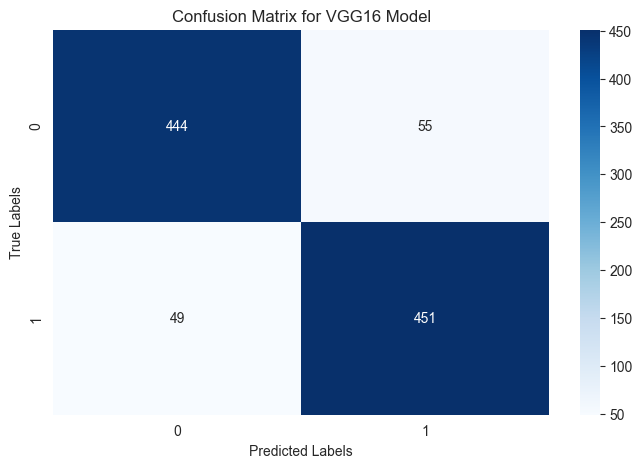

In [5]:
best_model = load_model('./vgg16_model6.h5')

vgg_predictions = best_model.predict(RGB_test_generator)
vgg_predictions = np.where(vgg_predictions > 0.5, 1, 0)
vgg_confusion_matrix = confusion_matrix(RGB_test_generator.classes, vgg_predictions.round())

plt.figure(figsize=(8, 5))
sns.heatmap(vgg_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for VGG16 Model')
plt.show()

### **Classification Report for VGG16 Model(Best Model)**

In [46]:
print(classification_report(RGB_test_generator.classes, vgg_predictions, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.90      0.89      0.90       499
   Malignant       0.89      0.90      0.90       500

    accuracy                           0.90       999
   macro avg       0.90      0.90      0.90       999
weighted avg       0.90      0.90      0.90       999



# **THANK YOU**